# Models evaluation

This notebook contains each of the selected models to evaluate:<br>


*   Decision Tree Classifier
*   Random Forest
*   Logistic Regression
*   Naïve Bayes Networks
*   Support Vector Machines

A statistical analysis is made for each of them, and the best model accuracy determines the classification model for this application.



## Libraries import



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import reciprocal, uniform
import Curva

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

#for word embedding
import gensim
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### [1. Naive](#Cap1)
### [2. Logistic Regression](#Cap2)
### [3. Classification tree](#Cap3)
### [4. Random forest](#Cap4)
### [5. SVM](#Cap5)

### Data loading

In [ ]:
# Importar conjunto de datos

df = pd.read_csv("cleaningDF_13agosto.csv", encoding = 'latin-1' )

df.dropna(subset = ["new_descripcion", "new_category"], inplace=True)
df = df.reset_index(drop=True)

In [ ]:
documents = df[["new_descripcion", "new_category"]].copy()

In [ ]:
# Cantidad de caracteres en una descripción por categoría

documents["char_count"] = documents["new_descripcion"].apply(lambda x: len(str(x)))

for i in documents["new_category"].unique():
    x = documents[documents["new_category"]==i]["char_count"].mean()
    print("Mean character for category",i,":", x)

Mean character for category Nuevo requerimiento : 104.6379477250726
Mean character for category Servicios : 56.83673469387755
Mean character for category Datos : 127.8148893360161
Mean character for category Visor : 93.51709401709402
Mean character for category GPS : 62.68905472636816
Mean character for category Funcionalidad : 92.4087591240876
Mean character for category Formulario : 123.1832191780822
Mean character for category Reporte : 138.59499431171787
Mean character for category Sistema : 93.98550724637681
Mean character for category Consultas : 103.24
Mean character for category App : 127.20930232558139
Mean character for category Otros : 58.63592233009709
Mean character for category Shape : 85.0952380952381


 *'Datos'* category is the main one, and the second with the higher number of characters that were used in ticket description.

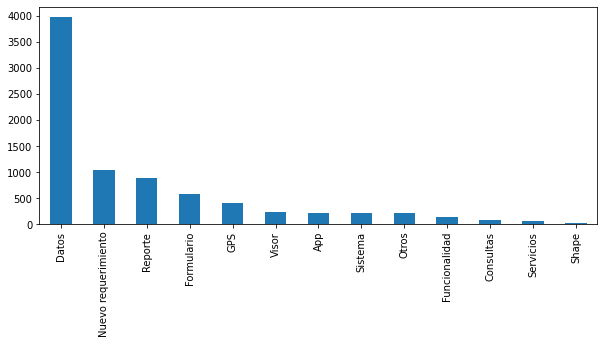

In [ ]:
# Visualización de categorías 

my_tags = documents.new_category.unique()
plt.figure(figsize=(10,4))
documents.new_category.value_counts().plot(kind='bar');

In [ ]:
def print_plot(index):
    example = documents[documents.index == index][["new_descripcion", "new_category"]].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [ ]:
print_plot(5000)

hace dias plataforma geolumina presenta error visualización lista haremos sección sam cargar datos sección sam toma darle clic mas cargar sección permite aprobar orden sucede volver guardar sección actividad carga sección sam desaparece lista haremos luego ello permite aprobar orden luego verificado si cargan haremos
Tag: Formulario


## 1. Naïve Bayes classifier<a class="anchor" id="Cap1"></a>

In [ ]:
X = df.new_descripcion
y = df.new_category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 19)

In [ ]:
# Ajuste del modelo Naive

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
# Pronóstico y evaluación del modelos

y_pred = nb.predict(X_test)

print('accuracy %s \n' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5629675810473815 

                     precision    recall  f1-score   support

Nuevo requerimiento       0.00      0.00      0.00        46
          Servicios       0.00      0.00      0.00        15
              Datos       0.54      0.99      0.70       769
              Visor       0.33      0.01      0.02       119
                GPS       0.00      0.00      0.00        21
      Funcionalidad       0.98      0.47      0.63        85
         Formulario       0.62      0.36      0.45       222
            Reporte       0.00      0.00      0.00        37
            Sistema       0.73      0.12      0.21       177
          Consultas       0.00      0.00      0.00        12
                App       0.00      0.00      0.00         3
              Otros       0.00      0.00      0.00        42
              Shape       0.00      0.00      0.00        56

           accuracy                           0.56      1604
          macro avg       0.25      0.15      0.16   

### Learning curve

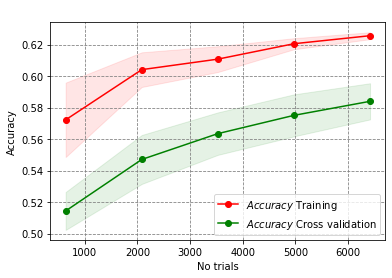

In [ ]:
X = df.new_descripcion
y = df.new_category

title = " "

cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = nb

Curva.plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=6);

By cross-validation, the Naïve Bayes classifier has an accuracy of 0.58. There is no evidence about its learning.

## 2. Logit (Logistic regression) (tf-idf)<a class="anchor" id="Cap2"></a>

In [ ]:
# Crear una columna con categorías numéricas

idx = documents["new_category"].unique()
val = np.arange(0,len(idx))
dic = pd.DataFrame(list(zip(idx,val)), index=idx)[1]
dic = dict(dic)

documents["Cat"] = documents["new_category"].map(dic)    # Asignación numérica a categorias 

In [ ]:
# Creación de variables dependientes e independientes

X = documents.new_descripcion
y = documents.new_category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 19)

In [ ]:
# Transformar los datos de texto apoyados en Tf-Idf

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
X_vectors_tfidf = tfidf_vectorizer.fit_transform(X)

In [ ]:
# Ajustar el modelo de clasificación

lr_tfidf = LogisticRegression(solver = 'liblinear', C=1.5, penalty = 'l1') # Se usa una penalización con norma L2
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

# Predicción de valores usando el conjunto de prueba

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))

                     precision    recall  f1-score   support

                App       0.43      0.20      0.27        46
          Consultas       0.00      0.00      0.00        15
              Datos       0.78      0.91      0.84       769
         Formulario       0.59      0.40      0.48       119
      Funcionalidad       0.50      0.29      0.36        21
                GPS       0.85      0.81      0.83        85
Nuevo requerimiento       0.57      0.59      0.58       222
              Otros       0.52      0.30      0.38        37
            Reporte       0.59      0.63      0.61       177
          Servicios       0.67      0.33      0.44        12
              Shape       0.00      0.00      0.00         3
            Sistema       0.38      0.14      0.21        42
              Visor       0.67      0.55      0.61        56

           accuracy                           0.70      1604
          macro avg       0.50      0.40      0.43      1604
       weighted avg   

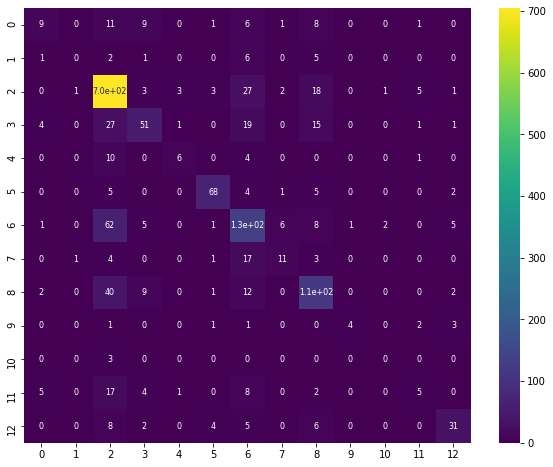

In [ ]:
# Graficar en un mapa de calor la matriz de confusión. El eje x son los valores pronósticados y el eje y los observados

conf = confusion_matrix(y_test, y_predict).astype("int")
plt.figure(figsize=(10,8))

sns.heatmap(conf, annot=True, annot_kws={"fontsize":8}, cmap="viridis");

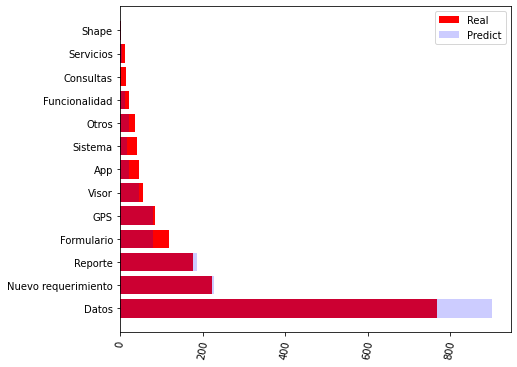

In [ ]:
real = y_test.value_counts()
predict = pd.Series(y_predict).value_counts()

plt.figure(figsize=(7,6))
plt.barh(real.index, real,color="r", label="Real")
plt.barh(predict.index, predict, alpha=0.2, color="b", label="Predict")
plt.legend()
plt.xticks(rotation=80);

Considering the data imbalance, the model overestimates values for *Datos* category, where it is the most frequent in Sigma.

### Learning curve

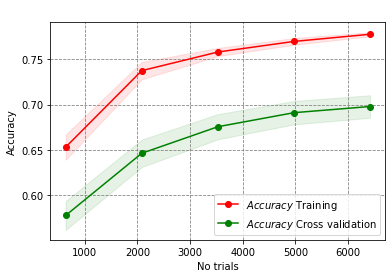

In [ ]:
X = X_vectors_tfidf

title = " "

cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = LogisticRegression(solver = 'liblinear', C=1.5, penalty = 'l1')

Curva.plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=6);

A cross-validation performance of approximately 0.71 is achieved. There is no signs of overlearning

## 3. Classification tree<a class="anchor" id="Cap3"></a>

## Hyperparameter identification with grid search (Gridsearch)

In [ ]:
model = GridSearchCV(DecisionTreeClassifier(max_depth=5, min_samples_split=2,
                                          criterion="mae"), cv=5,
                   param_grid={"criterion": ["gini", "entropy"],
                               "max_features":["auto", "sqrt", "log2"]})
model.fit(X_train_vectors_tfidf, y_train);

model.best_params_

{'criterion': 'gini', 'max_features': 'sqrt'}

In [ ]:
# Ajustar hiper-parámetros

Tree = DecisionTreeClassifier(criterion="entropy", max_features="auto")
Tree.fit(X_train_vectors_tfidf, y_train)

# Predicción de valores usando el conjunto de prueba

y_predict = Tree.predict(X_test_vectors_tfidf)

print(classification_report(y_test,y_predict))

                     precision    recall  f1-score   support

                App       0.26      0.22      0.24        46
          Consultas       0.11      0.13      0.12        15
              Datos       0.74      0.80      0.77       769
         Formulario       0.22      0.24      0.23       119
      Funcionalidad       0.30      0.38      0.33        21
                GPS       0.68      0.67      0.67        85
Nuevo requerimiento       0.44      0.40      0.42       222
              Otros       0.14      0.14      0.14        37
            Reporte       0.46      0.41      0.43       177
          Servicios       0.40      0.33      0.36        12
              Shape       0.00      0.00      0.00         3
            Sistema       0.39      0.21      0.28        42
              Visor       0.52      0.48      0.50        56

           accuracy                           0.58      1604
          macro avg       0.36      0.34      0.35      1604
       weighted avg   

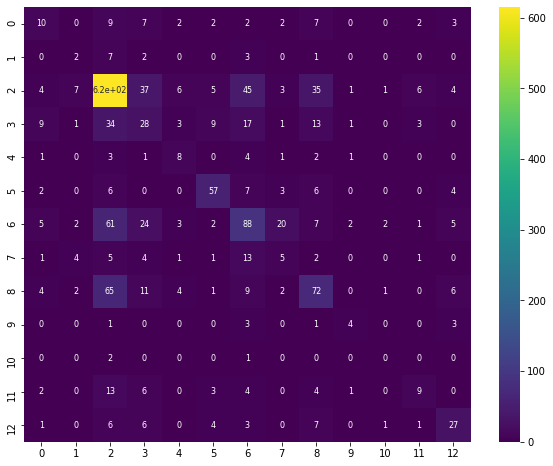

In [ ]:
# Graficar en un mapa de calor la matriz de confusión. El eje x son los valores pronósticados y el eje y los observados

conf = confusion_matrix(y_test, y_predict).astype("int")
plt.figure(figsize=(10,8))

sns.heatmap(conf, annot=True, annot_kws={"fontsize":8}, cmap="viridis");

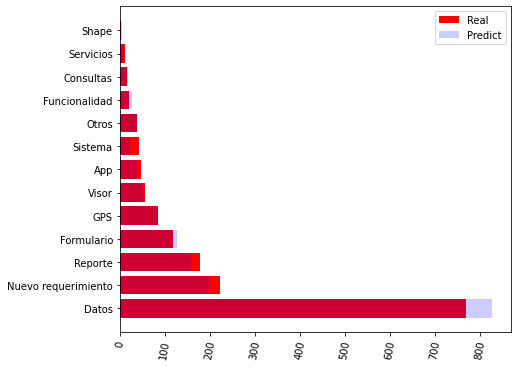

In [ ]:
real = y_test.value_counts()
predict = pd.Series(y_predict).value_counts()

plt.figure(figsize=(7,6))
plt.barh(real.index, real,color="r", label="Real")
plt.barh(predict.index, predict, alpha=0.2, color="b", label="Predict")
plt.legend()
plt.xticks(rotation=80);

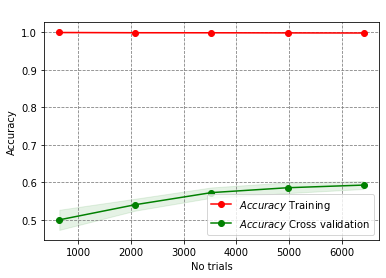

In [ ]:
X = X_vectors_tfidf

title = " "

cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = DecisionTreeClassifier(criterion="gini", max_features="auto")

Curva.plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=6);

The gap between validation and training is wide, what it means that clasification tree is learning the values on training phase and not identifying the paterns as we wish

## 4. Random Forest<a class="anchor" id="Cap4"></a>

In [ ]:
#model = GridSearchCV(RandomForestClassifier(n_estimators=1000), cv=5,
#                   param_grid={"max_depth": [None,3, 4, 5, 6],
#                               "max_features":["auto", "sqrt", "log2"],
#                              "criterion": ["gini", "entropy"]})
#model.fit(X_train_vectors_tfidf, y_train);

#model.best_params_

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt'}

In [ ]:
model.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features='sqrt')

In [ ]:
classifier = RandomForestClassifier(max_features='sqrt', n_estimators=1000)
classifier.fit(X_train_vectors_tfidf, y_train)
y_predict = classifier.predict(X_test_vectors_tfidf)

print(classification_report(y_test,y_predict))

                     precision    recall  f1-score   support

                App       0.69      0.24      0.35        46
          Consultas       0.00      0.00      0.00        15
              Datos       0.74      0.95      0.83       769
         Formulario       0.64      0.29      0.40       119
      Funcionalidad       1.00      0.43      0.60        21
                GPS       0.82      0.88      0.85        85
Nuevo requerimiento       0.57      0.65      0.61       222
              Otros       0.65      0.30      0.41        37
            Reporte       0.70      0.50      0.59       177
          Servicios       0.83      0.42      0.56        12
              Shape       1.00      0.33      0.50         3
            Sistema       0.64      0.21      0.32        42
              Visor       0.74      0.52      0.61        56

           accuracy                           0.71      1604
          macro avg       0.70      0.44      0.51      1604
       weighted avg   

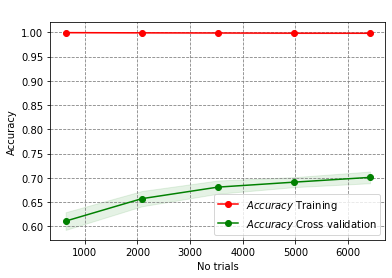

In [ ]:
X = X_vectors_tfidf

title = " "

cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = RandomForestClassifier(max_features='sqrt', n_estimators=1000)

Curva.plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=6);

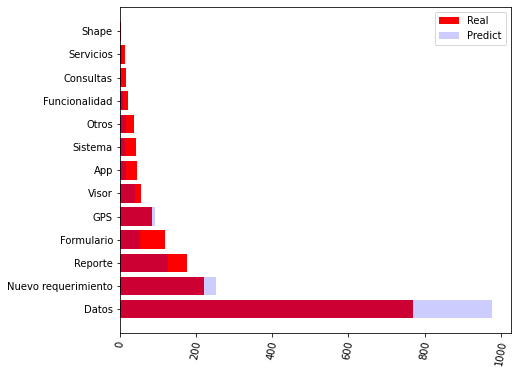

In [ ]:
real = y_test.value_counts()
predict = pd.Series(y_predict).value_counts()

plt.figure(figsize=(7,6))
plt.barh(real.index, real,color="r", label="Real")
plt.barh(predict.index, predict, alpha=0.2, color="b", label="Predict")
plt.legend()
plt.xticks(rotation=80);

## 5. SVM<a class="anchor" id="Cap5"></a>

In [ ]:
rnd_search_cv = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ("classifier", SVC()),])   

In [ ]:
svm_param_grid = {
    "classifier__class_weight": [None, "balanced"],
    "classifier__C": [1, 10, 100, 1000],
    "classifier__gamma": [0.001, 0.0001],
    "classifier__kernel": ["linear", "rbf",],
}

In [ ]:
search = RandomizedSearchCV(rnd_search_cv, param_distributions=svm_param_grid, verbose=8)
search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END classifier__C=100, classifier__class_weight=balanced, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.701 total time=  10.9s
[CV 2/5] END classifier__C=100, classifier__class_weight=balanced, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.684 total time=  11.1s
[CV 3/5] END classifier__C=100, classifier__class_weight=balanced, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.673 total time=  11.2s
[CV 4/5] END classifier__C=100, classifier__class_weight=balanced, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.679 total time=  11.3s
[CV 5/5] END classifier__C=100, classifier__class_weight=balanced, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.672 total time=  11.2s
[CV 1/5] END classifier__C=100, classifier__class_weight=balanced, classifier__gamma=0.001, classifier__kernel=rbf;, score=0.565 total time=  25.0s
[CV 2/5] END classifier__C=100,

RandomizedSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('classifier', SVC())]),
                   param_distributions={'classifier__C': [1, 10, 100, 1000],
                                        'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__gamma': [0.001, 0.0001],
                                        'classifier__kernel': ['linear',
                                                               'rbf']},
                   verbose=8)

In [ ]:
y_predict = search.predict(X_test)

print(classification_report(y_test,y_predict))

                     precision    recall  f1-score   support

                App       0.39      0.35      0.37        46
          Consultas       0.25      0.20      0.22        15
              Datos       0.80      0.88      0.84       769
         Formulario       0.52      0.50      0.51       119
      Funcionalidad       0.53      0.43      0.47        21
                GPS       0.85      0.80      0.82        85
Nuevo requerimiento       0.59      0.59      0.59       222
              Otros       0.48      0.30      0.37        37
            Reporte       0.61      0.59      0.60       177
          Servicios       1.00      0.42      0.59        12
              Shape       0.20      0.33      0.25         3
            Sistema       0.43      0.29      0.34        42
              Visor       0.65      0.57      0.61        56

           accuracy                           0.70      1604
          macro avg       0.56      0.48      0.51      1604
       weighted avg   

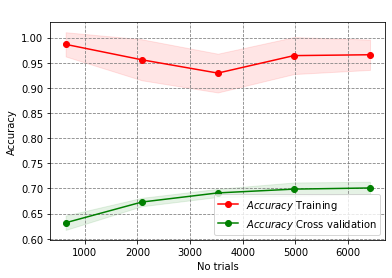

In [ ]:
X = df.new_descripcion

title = " "

cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = RandomizedSearchCV(rnd_search_cv, param_distributions=svm_param_grid, verbose=8)

Curva.plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=6);